In [1]:
Link = 'https://github.com/natsunoyuki/blog_posts/blob/main/data_science/Bayesian%20Optimization%20of%20Model%20Hyperparameters.ipynb'

In [2]:
pip install niapy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 176 kB 5.2 MB/s 


In [3]:
pip install sklearn 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=a5ce22269c74d9bb348630ab41664ac845b6dbfd724ebb059d1978809adf74f1
  Stored in directory: /root/.cache/pip/wheels/42/56/cc/4a8bf86613aafd5b7f1b310477667c1fca5c51c3ae4124a003
Successfully built sklearn


In [4]:
pip install sklearn-nature-inspired-algorithms

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 175 kB 4.8 MB/s 
     |████████████████████████████████| 22.3 MB 1.5 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
  Attempting uninstall: niapy
    Found existing installation: niapy 2.0.2
    Uninstalling niapy-2.0.2:
      Successfully uninstalled niapy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.5 requires scikit-learn>=1.0.0, but you have scikit-learn 0.24.2 which is incompatible.


In [5]:
pip install bayesian-optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
SEED = 1412
Test_Ratio = 0.2

In [7]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X,y = make_classification(n_samples=10000,n_features=5,n_informative=2,n_classes=2,n_clusters_per_class=1,flip_y=0.2,shuffle=False,random_state=SEED)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = Test_Ratio, random_state = SEED)



In [8]:
from sklearn.ensemble import RandomForestClassifier

def mdl_para_lst_maker():
    lst = []
    for n_estimator in range(50,501,50):
        for criterion in ['gini', 'entropy']:
            for max_feature in ['sqrt', 'log2', None]:
                MyDict = {'n_estimators':[n_estimator], 'criterion':[criterion], 'max_features':[max_feature], 'random_state':[SEED]}
                lst.append(MyDict)
    return lst 
    
mdl_para_lst = mdl_para_lst_maker()

def get_mdl_para(x):
    x = int(x)
    try:
        return mdl_para_lst[x]
    except:
        x = x%len(mdl_para_lst)
        print(f'Yo! X ({x}) for mdl is out of bounds!')
        return mdl_para_lst[x]

In [9]:
from niapy.algorithms.basic import FireflyAlgorithm
import numpy as np 

def NIA_FireFly():
    lst = []
    for population_size in range(10,101,10):#10
        for alpha in np.arange(0.10,0.21,0.01):#10
            for beta0 in range(10,101,10):#10
                for gamma in np.arange(0.05,1.01,0.05):#19
                    for theta in np.arange(0.05,1.01,0.05):#19
                        Algo = FireflyAlgorithm()
                        Algo.set_parameters(population_size=population_size, 
                        alpha=alpha, 
                        beta0=beta0, 
                        gamma=gamma, 
                        theta=theta,
                        seed=SEED
                        )
                        lst.append(Algo)
    return lst 

FA_lst = NIA_FireFly()

def get_algo(x):
    x = int(x)
    try:
        return FA_lst[x]
    except:
        print(f'Yo! X ({x}) for algo is out of bounds!')
        x = x%(len(FA_lst))
        return FA_lst[x]

In [10]:
from sklearn_nature_inspired_algorithms.model_selection import NatureInspiredSearchCV

Dict_combo = dict()

def Get_Score(mdl_val,algo_val):
    print(mdl_val,algo_val)
    mdl_val = int(mdl_val)
    algo_val = int(algo_val)
    print(mdl_val,algo_val)
    
    combo_str = f'{mdl_val}_{algo_val}'
    if combo_str in Dict_combo:
        return Dict_combo[combo_str]

    param_grid = get_mdl_para(mdl_val)

    algorithm = get_algo(algo_val)

    nia_search_mdl = NatureInspiredSearchCV(
        estimator=RandomForestClassifier(),
        param_grid=param_grid,
        algorithm=algorithm,
        runs=1
    )
    nia_search_mdl.fit(X_train, y_train)
    val = nia_search_mdl.score(X_test,y_test)
    Dict_combo[combo_str] = val 
    return val 


In [11]:
19*19*1000 * 100*3*3

324900000

In [12]:
324900000*6 ,32490000, (32490000/60), (32490000/60)/24, ((32490000/60)/24)/365 

(1949400000, 32490000, 541500.0, 22562.5, 61.81506849315068)

In [13]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
val = clf.score(X_test,y_test)
print(val)

0.8585


In [13]:
from bayes_opt import BayesianOptimization, UtilityFunction

# Define the metric to optimize over.
'''
def black_box_function(algo,mdl):
    return Get_Score(mdl,algo)
''' 

# Set range of C to optimize over. bayes_opt requires this to be a dictionary.
pbounds = {"algo_val": (0, len(FA_lst)-1), "mdl_val" : (0,len(mdl_para_lst)-1)}
print(pbounds)
#ptypes = {"algo_val": int, "mdl_val": int}

# Create BayesianOptimization object, and optimize (maximize) black_box_function.
optimizer = BayesianOptimization(f = Get_Score, pbounds = pbounds, verbose = 2, random_state = SEED)

optimizer.maximize(init_points = 51, n_iter = 71)

print("Best result: {}; f(x) = {}.".format(optimizer.max["params"], optimizer.max["target"]))

{'algo_val': (0, 439999), 'mdl_val': (0, 59)}
|   iter    |  target   | algo_val  |  mdl_val  |
-------------------------------------------------
44.37312093390081 387086.16294934315
44 387086
Fitting at most 1 candidates
Optimization finished, 1 candidates were fitted
| 1         | 0.8605    | 3.871e+05 | 44.37     |
25.916042978878316 28067.295704614095
25 28067
Fitting at most 1 candidates
Optimization finished, 1 candidates were fitted
| 2         | 0.862     | 2.807e+04 | 25.92     |
44.89426287782875 140794.95699856218
44 140794
Fitting at most 1 candidates
Optimization finished, 1 candidates were fitted
| 3         | 0.8605    | 1.408e+05 | 44.89     |
51.867185895021436 405425.0357125207
51 405425
Fitting at most 1 candidates
Optimization finished, 1 candidates were fitted
| 4         | 0.863     | 4.054e+05 | 51.87     |
32.79692004623707 171919.0576150966
32 171919
Fitting at most 1 candidates
Optimization finished, 1 candidates were fitted
| 5         | 0.861     | 1.719e+05

In [14]:
# Create optimizer and utility function objects.
optimizer = BayesianOptimization(f = None, pbounds = {"algo_val": (0, len(FA_lst)-1), "mdl_val" : (0,len(mdl_para_lst)-1)}, verbose = 2, random_state = SEED)
utility = UtilityFunction(kind = "ucb", kappa = 1.96, xi = 0.01)

# Optimization for loop.
for i in range(15):
    # Get optimizer to suggest a new parameter value to try.
    next_point = optimizer.suggest(utility)
    # Evaluate the output of the black_box_function using the new parameter value.
    target = Get_Score(**next_point)
    try:
        # Update the optimizer with the evaluation results. This needs to be in try-except
        # to prevent repeat errors from occuring.
        optimizer.register(params = next_point, target = target)
    except:
        pass
    
print("Best result: {}; f(x) = {:.3f}.".format(optimizer.max["params"], optimizer.max["target"]))

44.37312093390081 387086.16294934315
44 387086
49.71010033875881 394341.746767086
49 394341
Fitting at most 1 candidates
Optimization finished, 1 candidates were fitted
36.00911275665642 282372.12007014884
36 282372
Fitting at most 1 candidates
Optimization finished, 1 candidates were fitted
2.8893087878744073 52618.12577372927
2 52618
Fitting at most 1 candidates
Optimization finished, 1 candidates were fitted
24.56464016697844 284806.81848924945
24 284806
Fitting at most 1 candidates
Optimization finished, 1 candidates were fitted
31.602926761212817 285106.97603421356
31 285106
Fitting at most 1 candidates
Optimization finished, 1 candidates were fitted
54.63579186663414 394334.29448548227
54 394334
Fitting at most 1 candidates
Optimization finished, 1 candidates were fitted
39.61678609914196 284848.2861478052
39 284848
Fitting at most 1 candidates
Optimization finished, 1 candidates were fitted
28.525809254078194 284804.8614415308
28 284804
Fitting at most 1 candidates
Optimization 

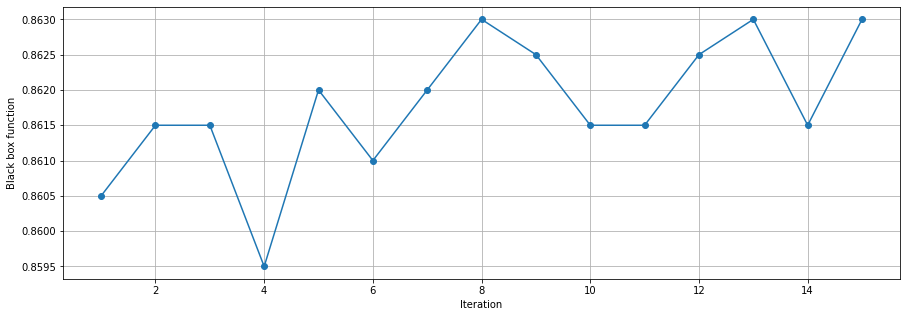

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize = (15, 5))
plt.plot(range(1, 1+len(optimizer.space.target)), optimizer.space.target, "-o")
plt.grid(True)
plt.xlabel("Iteration")
plt.ylabel("Black box function")
plt.show()

NEED TO BE CHECKED BEFORE RUNNING

In [16]:
import skopt

# Unlike bayes_opt, skopt requires that the search boundary is given as an array of tuples.
p_bounds = [(0.1, 10.0)]

opt = skopt.Optimizer(dimensions = p_bounds,
                base_estimator = "GP", # Gaussian Process regressor.
                n_initial_points = 5, 
                initial_point_generator = 'random', 
                acq_func = "LCB", # Lower Confidence Bounds.
                random_state = 0)

for i in range(15):
    next_point_to_try = opt.ask() # next_point is returned as a list.
    # Unlike bayes_opt, skopt performs minimization. Therefore we use -black_box_function(*next_point).
    loss_to_minimize = -Get_Score(*next_point_to_try)
    result = opt.tell(next_point_to_try, loss_to_minimize)
    
# Again, don't forget to use the negative of result as we are performing minimization here.
print("Best result: {}, f(x) = {:.3f}.".format(result["x"], -result["fun"]))

ModuleNotFoundError: ignored

In [ ]:
plt.figure(figsize = (15, 5))
plt.plot(range(1, len(result["func_vals"])+1), result["func_vals"], "-o")
plt.grid(True)
plt.xlabel("iteration")
plt.ylabel("loss_function")
plt.show()

function ClickConnect(){

console.log("Working"); 
document.querySelector("#comments > span").click() 
}
setInterval(ClickConnect,5000)